In [27]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colors as colors
import matplotlib.patches as patches
import h5py
import multihist as mh
import shutil

import os
import sys
sys.path.append(".")
from collections import defaultdict
import math
import json
import numpy as np

import ACClasses
import helpers
import os, sys
from glob import glob
from datetime import datetime

import inference_interface

# Setting Up Detector config 

In [28]:
Area_Xenon1t_lid = 48.*48.*np.pi  # cm^2
Area_Xenon1t = Area_Xenon1t_lid + np.pi*2.*48. * 100.

Area_LZPTFE = np.pi*2.*75. * 150. #cm^2
XENONdetector = ACClasses.Detector(TPCHeight=100., 
               TPCRadius = 48.,
               BelowCathodeHeight = 10.,
               FiducialCut = 10.,
               ExtractionEfficiency = 0.96,
               g2 = 11.4,
               g1 = 0.14, #Added this
               SEGain = 20,                                   
               LCETop = 0.32,  # These are guesses to get at g1 of 0.14, and match the relative LCE on the wiki
               LCEBottom = 0.54,
               PMTDetectionProb = 0.3,
               PMTDarkRate = 50,
               DriftField = 150,
               ElectronLifetime = 0.65,
               PMTDensity = 250./Area_Xenon1t_lid
                             )
XENONnTdetector = ACClasses.Detector(TPCHeight=149., 
               TPCRadius = 66.,
               BelowCathodeHeight = 12.,
               FiducialCut = 10.,
               ExtractionEfficiency = 0.96,
               g2 = 16,
               g1 = 0.14, #Added this
               SEGain = 35,
               LCETop = 0.26,
               LCEBottom = 0.44,
               PMTDetectionProb = 0.3,
               PMTDarkRate = 50,
               DriftField = 100, #need to download data for lower drift field
               ElectronLifetime = 8,
               PMTDensity = 250./Area_Xenon1t_lid
                             )

DARWINdetector = ACClasses.Detector(TPCHeight=240., #TPCHeight=260., 240
               TPCRadius = 130., #TPCRadius = 130 
               BelowCathodeHeight = 10., 
               FiducialCut = 10.,
               ExtractionEfficiency = 0.96,
               g2 = 43.515 ,#43.515, # g2 
               g1 = 0.1423, #Added this
               SEGain = 400, #40 to 400
               LCETop = 0.26,
               LCEBottom = 0.44,
               PMTDetectionProb = 0.32,
               PMTDarkRate = 50,
               DriftField = 200,
               ElectronLifetime = 10,
               PMTDensity = 250./Area_Xenon1t_lid
                    )

XLZDdetector_40T = ACClasses.Detector(TPCHeight=200., 
                TPCRadius = 298/2., #TPCRadius = 130 cm 
                BelowCathodeHeight = 10., 
                FiducialCut = 7.,
                ExtractionEfficiency = 0.90,
                g2 = 44.653 ,#43.515, # g2 
                g1 = 0.27, #Added this
                SEGain = 40, 
                LCETop = 0.184,
                LCEBottom = 0.385,
                PMTDetectionProb = 0.34,
                PMTDarkRate = 18,
                DriftField = 240,
                ElectronLifetime = 10,
                PMTDensity = 250./Area_Xenon1t_lid
                        )

XLZDdetector_60T = ACClasses.Detector(TPCHeight=298., 
                TPCRadius = 298/2., #TPCRadius = 130 cm 
                BelowCathodeHeight = 10., 
                FiducialCut = 7.,
                ExtractionEfficiency = 0.90,
                g2 = 44.653 ,#43.515, # g2 
                g1 = 0.27, #Added this
                SEGain = 40, 
                LCETop = 0.159,
                LCEBottom = 0.333,
                PMTDetectionProb = 0.34,
                PMTDarkRate = 18,
                DriftField = 240,
                ElectronLifetime = 10,
                PMTDensity = 250./Area_Xenon1t_lid
                        )
XLZDdetector_80T = ACClasses.Detector(TPCHeight=396.,
                TPCRadius = 298/2., #TPCRadius = 130 cm 
                BelowCathodeHeight = 10., 
                FiducialCut = 7.,
                ExtractionEfficiency = 0.90,
                g2 = 44.653 ,#43.515, # g2 
                g1 = 0.27, #Added this
                SEGain = 40, #40 to 400
                LCETop = 0.159,
                LCEBottom = 0.311,
                PMTDetectionProb = 0.34,
                PMTDarkRate = 18,
                DriftField = 290,
                ElectronLifetime = 10,
                PMTDensity = 250./Area_Xenon1t_lid
                        )
"""
A note on LCE values for accidentals : From Owen's past studies with ANTS2 - using the XLZD geometry scaled to 60 and 80 T respectively.

**40T LCe:**

Total avg: -- (Rob’s Thesis 0.57) 
Bot avg : --
Top avg : --
Top/(Bot+Top) ratio: 0.324 Owen says it doesn't change much 
-----------------------------
**60T LCe:**

Total avg: 0.578 (Rob’s Thesis 0.493) 
Bot avg : 0.391
Top avg : 0.187
Top/(Bot+Top) ratio: 0.324
-----------------------------
**80T LCe:**
Total avg: 0.496 (Rob’s Thesis 0.471)
Bot avg : 0.328
Top avg : 0.168
Top/(Bot+Top) ratio: 0.339
-----------------------------
I would propose that we adopt Rob’s total avg and apply the top/bot ratio for the LCE in the accidentals:
------------------------
So for 40T :
LCeTop: 0.57 * 0.324 = 0.184
LCeBot: 0.57 * (1-0.324) = 0.385
---------------------------
So for 60T :
LCeTop: 0.493 * 0.324 = 0.159
LCeBot: 0.493 * (1-0.324) = 0.333 
------------------------
So for 80T :
LCeTop: 0.471 * 0.339 = 0.159
LCeBot: 0.493 * (1-0.339) = 0.311 
---------------------------

"""
#detector = XENONdetector
#detector = XENONnTdetector
detector = XLZDdetector_40T

particleBackgroundsXENON1t = ACClasses.ParticleBackground(
        detector = detector,
        A1_cevns = 915, # NR background's CEvNS two exponentials. These come from a rough fit to the LZ background spectra
        b1_cevns = 0.5, # keV
        A2_cevns = 0.083, # events per (kev tonne year)
        b2_cevns = 16.7, # keV
        A_neutrons_fiducial = 0.005/Area_Xenon1t, # times 1 tonne to remove mass dependence Fig 8 in https://arxiv.org/pdf/1512.07501.pdf
        #A_neutrons_edge = 125 * 2.0/Area_Xenon1t, # times 2 tonnes to remove mass dependence
        A_neutrons_edge = 125 * 2.0/Area_Xenon1t, # times 2 tonnes to remove mass dependence
        b_neutrons = 25., # keV
        FlatERRate_internal = 10.0,  # events per (kev, tonne, year) prediction for nT,  # Rn, Kr - events per (kev tonne year)
        FlatErRate_external = 100./Area_Xenon1t,   #events per (kev * yr* cm^2) (not per mass), only close to the walls in 1-12 keV from 1T; from https://arxiv.org/pdf/1512.07501.pdf
                        )
particleBackgrounds = particleBackgroundsXENON1t
particleBackgrounds.FlatERRate_internal = particleBackgrounds.FlatERRate_internal/100.
particleBackgrounds.FlatErRate_external = particleBackgrounds.FlatErRate_external/100.

''' Assume all neutrons come in from the outside, hence the rate scales with area, not with LXe mass.'''
''' The materials contribution is also approximately flat below 12 keV. This is from MC prediction for 1T,
giving the rate as function of fiducial mass. This is strongly dominated by events near the wall. Since
this bg is thus interacting mostly outside the fiducial volume, we take this rate as what is going on
near the wall. Since the background comes from surrounding stuff, it should scale with wall area. '''

#instrumentalBackgrounds = ACClasses.InstrumentalBackground(
#        detector = detector,
#        A_unexplainedLoneS2 = 0.6/Area_Xenon1t,  # Hz/cm^2; from XENON1T 10.1103/PhysRevLett.123.251801 and 10.1103/PhysRevD.106.022001
#        b_unexplainedLoneS2 = 0.43,  # based on spectrum in above citations and Kopec, A. et al. Correlated single- and few-electron backgrounds milliseconds after interactions in dual-phase liquid xenon time projection chambers. J Instrum 16, P07014,
#        unexplainedLoneS1Rate = 30000./Area_LZPTFE # From https://docs.google.com/presentation/d/1QfHtG9H1M0ypoMsY4n73dK6WjzXPhpFDmVMYRyO-mFI/edit#slide=id.g17b2ed9eb9a_0_0 slide 24
#        )
#instrumentalBackgrounds = ACClasses.InstrumentalBackground(
#        detector = detector,
#        A_unexplainedLoneS2 = .5/Area_Xenon1t,  # Hz/cm^2; to match lone S2 rate reoprted in XENON1T above 8 PE
#       # b_unexplainedLoneS2 = 1.6,  # to match lone S2 spectrum observed in XENON1T
#        b_unexplainedLoneS2 = 1.1,  # to match lone S2 spectrum observed in XENON1T
#        unexplainedLoneS1Rate = 30000./Area_LZPTFE, # # to match the lone S1 rate observed in XENON1T
#        S1MisclassificationProb = 0.01, # Probability to misclassify a signal from SE as an S1
#        #unexplainedLoneS1Rate = 0
#        )
instrumentalBackgrounds1T = ACClasses.InstrumentalBackground(
        detector = detector,
        A_unexplainedLoneS2 = 20.*6e9/Area_Xenon1t/ACClasses.SecondsPerYear,  # /(yr cm^2); to match lone S2 rate reoprted in XENON1T above 8 PE
        b1_unexplainedLoneS2 = 0.3,  # to match lone S2 spectrum observed in XENON1T
        b2_unexplainedLoneS2 = 1.8,  # to match lone S2 spectrum observed in XENON1T
        r_unexplainedLoneS2 = 0.9999,  # to match lone S2 spectrum observed in XENON1T
        c_unexplainedLoneS2 = 20.*450/Area_Xenon1t/ACClasses.SecondsPerYear,  # to match lone S2 spectrum observed in XENON1T
        unexplainedLoneS1Rate = 30000./Area_LZPTFE, # # to match the lone S1 rate observed in XENON1T
        S1MisclassificationProb = 0.00003, # Probability to misclassify a signal from SE as an S1. This is a wild guess
        )
#settings
instrumentalBackgrounds = instrumentalBackgrounds1T

#ERChargeYield = 30.      #electrons/keV  #https://link.springer.com/content/pdf/10.1140/epjc/s10052-018-5801-5.pdf
#ERLightYield = 40.       #photons/keV     # also see https://arxiv.org/pdf/1512.07501.pdf
#NRChargeYield = 6.       #electrons/keV   at 5 keV
#NRLightYield = 6.        #photons/keV      at 5 keV https://www.sciencedirect.com/science/article/pii/S0370269311012822,https://arxiv.org/pdf/1512.07501.pdf

the fiducial mass is 36.35 tonnes
		the active mass is 40.02 tonnes
		the below-cathode mass is 2.00 tonnes
		the drift speed is 131.03cm/ms
		the max drift time is 1.53ms
		the number of PMTs is 2408 
		g1 is 0.27


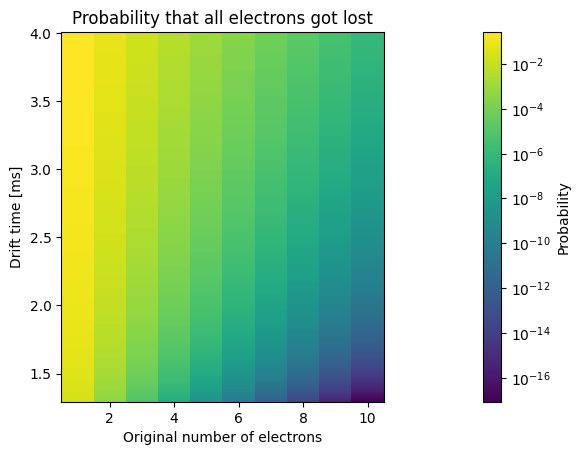

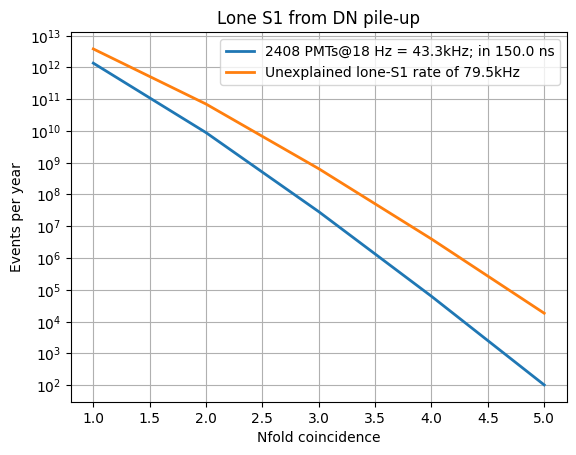

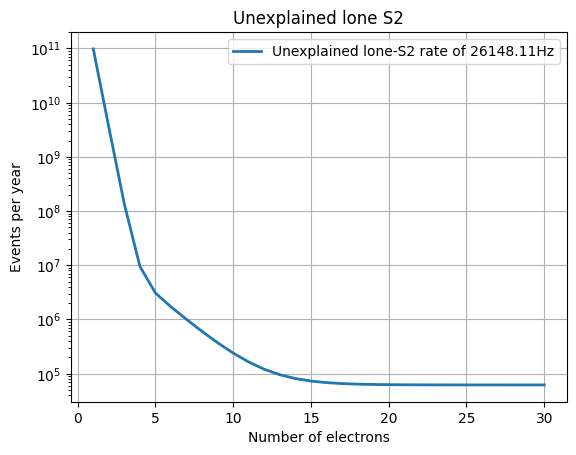

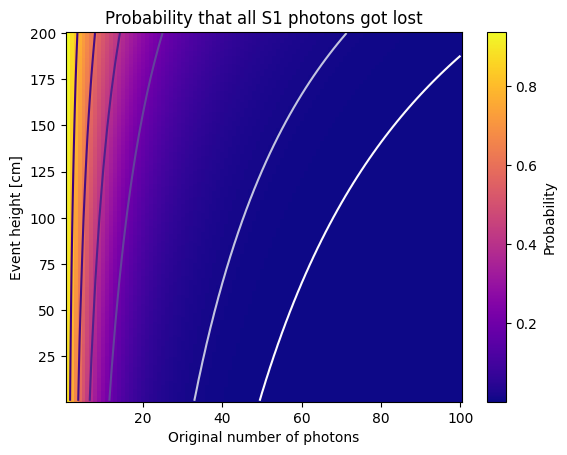

370521.1759094712
63925.352629088615
61859.52795459195
Lone S2 rate above 8 e-: 0.06350556496530986 Hz


In [29]:
print(detector)
instrumentalBackgrounds.PlotElectronLossProbability()
instrumentalBackgrounds.PlotDarkNoiseRate()
instrumentalBackgrounds.PhotonLossProbability()
loneS2perYear = 0.
for i in range(20):
    if i < 8:
        continue
    loneS2perYear = loneS2perYear + instrumentalBackgrounds.RUnexplainedS2(i)
print(instrumentalBackgrounds.RUnexplainedS2(9))
print(instrumentalBackgrounds.RUnexplainedS2(18))
print(instrumentalBackgrounds.RUnexplainedS2(27))
print("Lone S2 rate above 8 e-: " + str(loneS2perYear/ACClasses.SecondsPerYear) + " Hz")

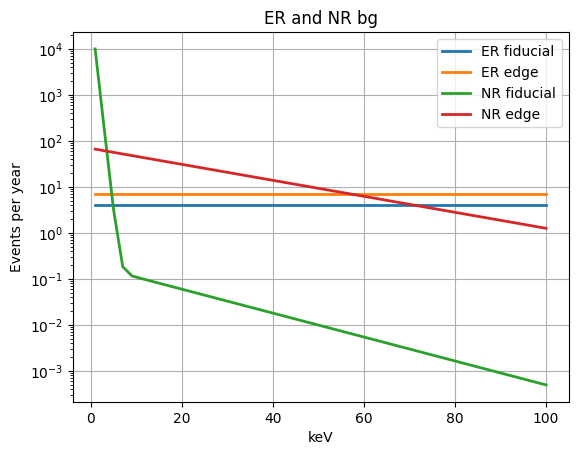

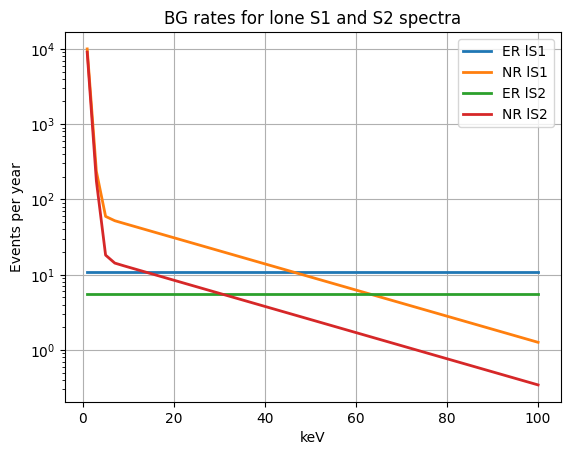

In [30]:
#Particle backgrounds

## In energy space

###This part is just to check that the energy spectra match whatever is expected from simulations
fig_bg, ax_bg = plt.subplots()
x_bg = np.linspace(1, 100, 50) #keV
y_bger_in = particleBackgrounds.BackgroundSpectrum(x_bg, "ER", "internal", detector.activeMass, -1)
y_bger_ex = particleBackgrounds.BackgroundSpectrum(x_bg, "ER", "external", -1, detector.TPCArea)

y_bgnr_in = particleBackgrounds.BackgroundSpectrum(x_bg, "NR", "internal", detector.activeMass, -1)
y_bgnr_ex = particleBackgrounds.BackgroundSpectrum(x_bg, "NR", "external", -1, detector.TPCArea)

ax_bg.semilogy(x_bg, y_bger_in, linewidth=2.0, label="ER fiducial")
ax_bg.semilogy(x_bg, y_bger_ex, linewidth=2.0, label="ER edge")
ax_bg.semilogy(x_bg, y_bgnr_in, linewidth=2.0, label="NR fiducial")
ax_bg.semilogy(x_bg, y_bgnr_ex, linewidth=2.0, label="NR edge")

ax_bg.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=25))
ax_bg.grid()
ax_bg.legend()
ax_bg.set_xlabel("keV")
ax_bg.set_ylabel("Events per year")
ax_bg.set_title("ER and NR bg")
plt.show()

## Now we collect those sources and detector locations that can create LS1 or LS2 signals
### Backgrounds relevant to lone-s1
y_bger_ls1 = particleBackgrounds.BackgroundSpectraForLone(x_bg, "S1", "ER")
y_bgnr_ls1 = particleBackgrounds.BackgroundSpectraForLone(x_bg, "S1", "NR")

### Backgrounds relevant to lone-s2
y_bger_ls2 = particleBackgrounds.BackgroundSpectraForLone(x_bg, "S2", "ER")
y_bgnr_ls2 = particleBackgrounds.BackgroundSpectraForLone(x_bg, "S2", "NR")

fig_bg2, ax_bg2 = plt.subplots()
ax_bg2.semilogy(x_bg, y_bger_ls1, linewidth=2.0, label="ER lS1")
ax_bg2.semilogy(x_bg, y_bgnr_ls1, linewidth=2.0, label="NR lS1")
ax_bg2.semilogy(x_bg, y_bger_ls2, linewidth=2.0, label="ER lS2")
ax_bg2.semilogy(x_bg, y_bgnr_ls2, linewidth=2.0, label="NR lS2")

ax_bg2.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=25))
ax_bg2.grid()
ax_bg2.legend()
ax_bg2.set_xlabel("keV")
ax_bg2.set_ylabel("Events per year")
ax_bg2.set_title("BG rates for lone S1 and S2 spectra")
plt.show()


It may take a moment for the blurring to finish.
It may take a moment for the blurring to finish.


/var/folders/11/qrrzf16128s2xj54lz_vslsm0000gn/T/ipykernel_31787/3373962338.py:79: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 2 Axes> than <Figure size 640x480 with 2 Axes> which fig.colorbar is called on.
  fig_xx.colorbar(im_xxx, ax=ax_xxx, pad=0.05, label="Rate")


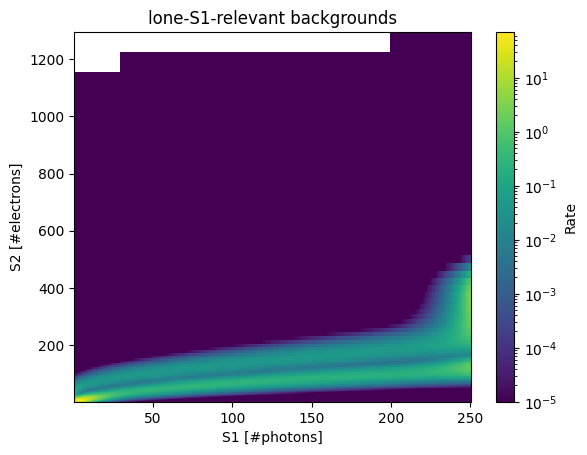

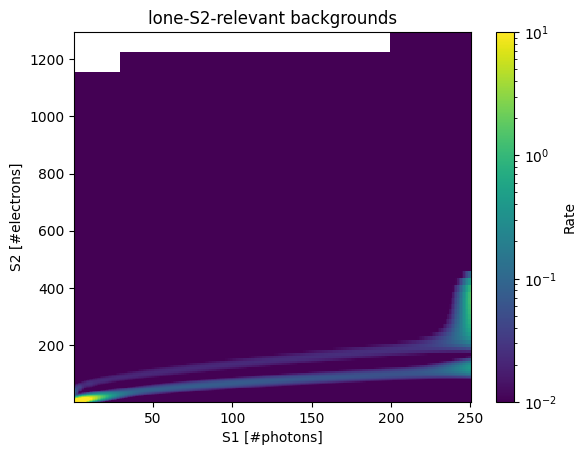

In [31]:
## Now convert those spectra to number-of-quanta space
S1q = []
S2q = []
Rq = []

energyRange = 15 # keV 
maxS1Range = 250
maxS2Range = 250

binwidth = 0.25 # keV 
''' We want finer binning than 1 keV, otherwise the spectra in 
    S1/S2 are not continuous. 
    '''
x_bg_l = np.linspace(0, energyRange, int(energyRange/binwidth))

#For the lone S1 signals:
def FillMatrix(a, b, c):
    S1q.append(a)
    S2q.append(b)
    Rq.append(c)


''' Get the central values for the number of S1 and S2 quanta produced. '''
for x in x_bg_l:
    if x < binwidth:
        continue
    a, b = detector.EnergyToQuanta(x,"ER")
    c = particleBackgrounds.BackgroundSpectraForLone(x, "S1", "ER")
    FillMatrix(a, b, c)
    ''' Due to the quenching, the ER and NR energy to quanta conversion
    is at different scales - at the same energy, NR produce less quanta
    and we have to include higher energies.'''
    a, b = detector.EnergyToQuanta(x*2.,"NR") 
    c = particleBackgrounds.BackgroundSpectraForLone(x*2., "S1", "NR")
    FillMatrix(a, b, c)    

''' Now we apply a gaussian smearing to recreate the statistical fluctuations in the 
    number of quanta produced. This does not take the anti-correlation into account. '''    
S1_forLS1, S2_forLS1, R_forLS1 = ACClasses.GaussianFilterGPT(Rq, S1q, S2q, binwidth, maxS1Range, maxS2Range, 0.2, detector.g2)

''' Make a nice plot '''
X_S1, Y_S2 = np.meshgrid(S1_forLS1, S2_forLS1)  
fig_xx, ax_xx = plt.subplots()    
max_val = np.max(R_forLS1[R_forLS1>0])
im_xx = ax_xx.pcolormesh(S1_forLS1, S2_forLS1, R_forLS1, norm=colors.LogNorm(vmin=1e-5,vmax=max_val))
ax_xx.set_xlabel("S1 [#photons]")
ax_xx.set_ylabel("S2 [#electrons]")
ax_xx.set_title("lone-S1-relevant backgrounds")
fig_xx.colorbar(im_xx, ax=ax_xx, pad=0.05, label="Rate")


S1q_2 = []
S2q_2 = []
Rq_2 = []

def FillMatrix_2(a, b, c):
    S1q_2.append(a)
    S2q_2.append(b)
    Rq_2.append(c)
#For the lone S2 signals:
for x in x_bg_l:
    if x < binwidth:
        continue
    a, b = detector.EnergyToQuanta(x,"ER")
    c = particleBackgrounds.BackgroundSpectraForLone(x, "S2", "ER")
    FillMatrix_2(a, b, c)
    a, b = detector.EnergyToQuanta(x*2.,"NR")
    c = particleBackgrounds.BackgroundSpectraForLone(x*2., "S2", "NR")
    FillMatrix_2(a, b, c) 

S1_forLS2, S2_forLS2, R_forLS2 = ACClasses.GaussianFilterGPT(Rq_2,S1q_2,S2q_2,binwidth, maxS1Range, maxS2Range, 0.2, detector.g2)


fig_xxx, ax_xxx = plt.subplots()   
ax_xxx.set_xlabel("S1 [#photons]")
ax_xxx.set_ylabel("S2 [#electrons]")
ax_xxx.set_title("lone-S2-relevant backgrounds")
im_xxx = ax_xxx.pcolormesh(S1_forLS2, S2_forLS2,  R_forLS2,norm=colors.LogNorm(vmin=0.01,vmax=10)) 
fig_xx.colorbar(im_xxx, ax=ax_xxx, pad=0.05, label="Rate")


6070.46468942173, 5729.500817013424


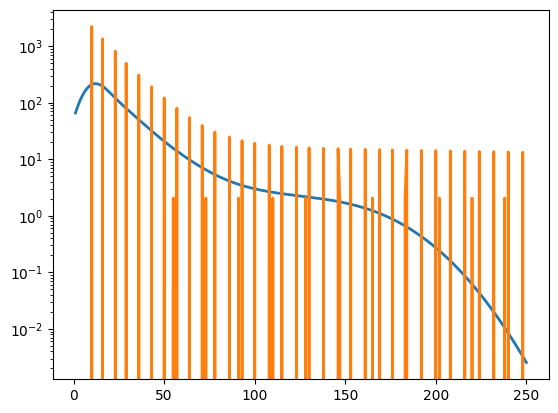

In [32]:
##Lone S1 from charge insensitive volume

S1only_FromCIV = np.arange(1, maxS1Range + 1, maxS1Range/250)


Rq_CIV = []
for x in S1only_FromCIV:
    Rq_CIV.append(0.0)
    
def FillCIV(x, R):
    PE = 0
    for i in S1only_FromCIV:
        if (abs(i-x) < 1):
            PE = int(i)
            break
    if (PE > 1):  #Otherwise, the number of PE created is out of range of the histogram
        index = int((PE - 1)*(250/maxS1Range)) 
        Rq_CIV[index] = Rq_CIV[index] + R     
for x in x_bg_l:

    if x < binwidth:
        continue
    a, b = detector.EnergyToQuanta(x,"ER")
    FillCIV(a+b, particleBackgrounds.BackgroundSpectrumFromCIV(x,"ER"))
    a, b = detector.EnergyToQuanta(x*2.,"NR")    
    FillCIV(a+b, particleBackgrounds.BackgroundSpectrumFromCIV(x,"NR"))

''' Now we apply a gaussian smearing to recreate the statistical fluctuations in the 
    number of quanta produced. This does not take the anti-correlation into account. '''    
R_LS1_ChargeIns = ACClasses.GaussianFilter1D(Rq_CIV, S1only_FromCIV, 1., maxS1Range, 1)

fig_bg3, ax_bg3 = plt.subplots()
ax_bg3.semilogy(S1only_FromCIV, R_LS1_ChargeIns, linewidth=2.0, label="Lone S1 from CIV")
ax_bg3.semilogy(S1only_FromCIV, Rq_CIV, linewidth=2.0, label="Lone S1 from CIV")



Text(0.5, 1.0, 'Rate of lone S1 from rad. backgrounds in active volume and in CIV')

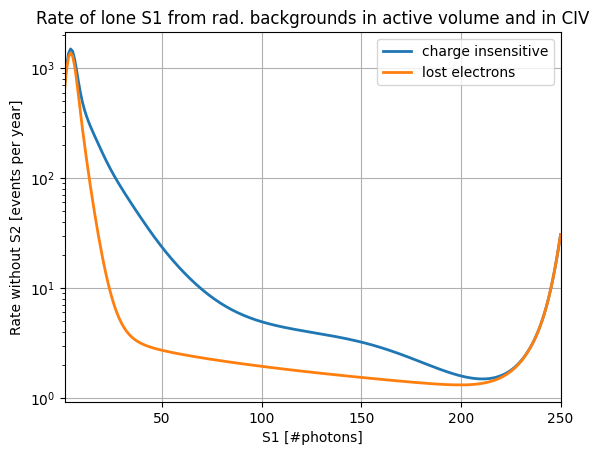

In [33]:
# Lone S1 from events where all e- are absorbed in active volume


R_LS1_Rad = []
R_LS1_RadChargeIns = [] # for the sum of the two components
x_LS1 = []
for i in range(len(R_forLS1)): # loop number of S1
    R_lost = 0.
    index = 1 + i*(maxS1Range/250) 
   
    x_LS1.append(index)                
    for j in range(len(R_forLS1[0])): 
        nsamples = 10
        for k in range(nsamples):
            R_lost = R_lost + R_forLS1[i,j]/nsamples*instrumentalBackgrounds.P_AllElectronsLost(j,k/nsamples * detector.MaxDriftTime)
    R_LS1_Rad.append(R_lost)
    R_LS1_RadChargeIns.append(R_lost+R_LS1_ChargeIns[i])
fig_noS2, ax_noS2 = plt.subplots()
ax_noS2.semilogy(x_LS1, R_LS1_RadChargeIns, linewidth=2.0, label="charge insensitive")
ax_noS2.semilogy(x_LS1, R_LS1_Rad, linewidth=2.0,  label="lost electrons")
ax_noS2.legend()

plt.xlim([1, 250]) 
ax_noS2.grid()
ax_noS2.set_xlabel("S1 [#photons]")
ax_noS2.set_ylabel("Rate without S2 [events per year]")
ax_noS2.set_title("Rate of lone S1 from rad. backgrounds in active volume and in CIV")   


In [34]:
# Turn the axis from 'quanta' to 'PE', and add DN

x_DN = np.linspace(1, 8, 8)
y_DNCoincidenceRate = instrumentalBackgrounds.DNCoincidenceRate(x_DN)

x_LS1_PE = []
R_LS1_FromCIV_PE = [] 
R_LS1_Rad_PE = [] 

# Apply g1; axis is in PE after this
# In principle, we also have to think about coincidences between DC pile-up and real light,
# but as long as the rates are this low, the chance of that is negligible

for i in range(1,round(len(R_LS1_Rad)*detector.g1)):
    R_LS1_FromCIV_PE.append(R_LS1_ChargeIns[round(i/detector.g1)])
    R_LS1_Rad_PE.append(R_LS1_Rad[round(i/detector.g1)])
    x_LS1_PE.append(i)



Text(0.5, 1.0, 'Rate of S2 from rad. backgrounds in active volume without S1')

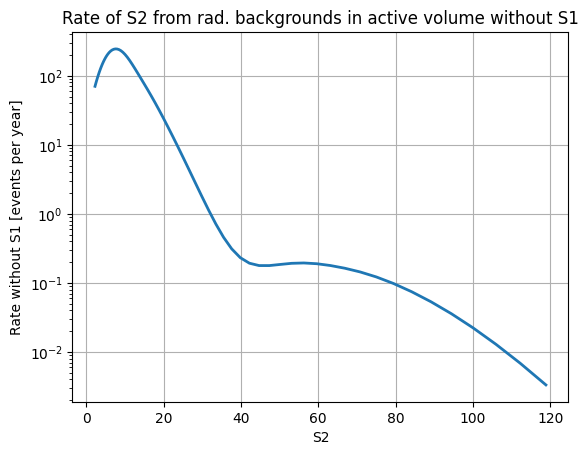

In [35]:
# Lone-S2  
#S1_2, S2_2, R_2, intrinsic only, since ext. events will be rejected from x-y position reconstruction based on S2 position
R_LS2 = []
x_LS2 = []


for j, k in enumerate(S2_forLS2[0]):
    R_lost = 0.
    x_LS2.append(k)    
    for i in range(1,len(R_forLS2)): 
        R_lost = R_lost + R_forLS2[i,j]*instrumentalBackgrounds.P_AllPhotonsLost(i,detector.height/2.) #Fixme, for now, all events produced in the center
    R_LS2.append(R_lost)
fig_noS1, ax_noS1 = plt.subplots()
ax_noS1.semilogy(x_LS2[0:70], R_LS2[0:70], linewidth=2.0)
ax_noS1.grid()
ax_noS1.set_xlabel("S2")
ax_noS1.set_ylabel("Rate without S1 [events per year]")
ax_noS1.set_title("Rate of S2 from rad. backgrounds in active volume without S1")

In [36]:
x_LS2_below_200 = [x for x in x_LS2 if x <= 200]
len_x_LS2_below_200 = len(x_LS2_below_200)
R_LS2_below_200 = R_LS2[0:len_x_LS2_below_200]


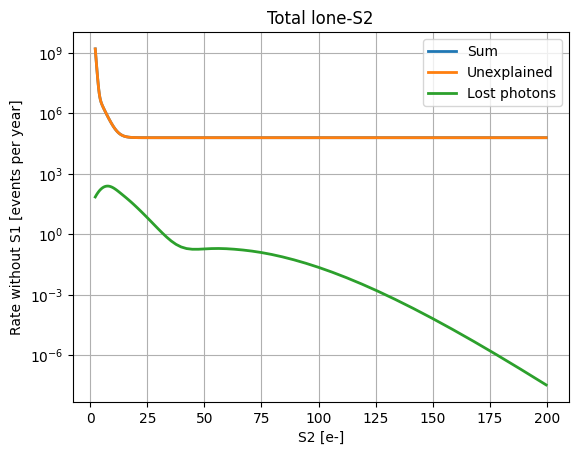

In [37]:
#Add lone-S2 unexplained

R_LS2_all = []
R_LS2_unexpl = []

for k, n in enumerate(x_LS2_below_200):
    Runexplained = instrumentalBackgrounds.RUnexplainedS2(n)
    #Runexplained=0
    R_LS2_unexpl.append(Runexplained)
    R_LS2_all.append( R_LS2[k] + Runexplained) 
fig_noS1tot, ax_noS1tot = plt.subplots()
ax_noS1tot.semilogy(x_LS2_below_200, R_LS2_all, linewidth=2.0, label="Sum")
ax_noS1tot.semilogy(x_LS2_below_200, R_LS2_unexpl, linewidth=2.0, label="Unexplained")
ax_noS1tot.semilogy(x_LS2_below_200, R_LS2_below_200, linewidth=2.0, label="Lost photons")



ax_noS1tot.grid()
ax_noS1tot.legend()

ax_noS1tot.set_xlabel("S2 [e-]")
ax_noS1tot.set_ylabel("Rate without S1 [events per year]")
ax_noS1tot.set_title("Total lone-S2")
plt.savefig("lone_S2.pdf", format="pdf",bbox_inches="tight")

#Added to convert electrons to PE
x_LS2_PE = []

x_LS2_PE = [x*detector.g2 for x in x_LS2_below_200]


0: 1, 3802264500658.909
1: 2, 70044062431.98468
2: 3, 645456819.3385507
3: 4, 4287353.2589898


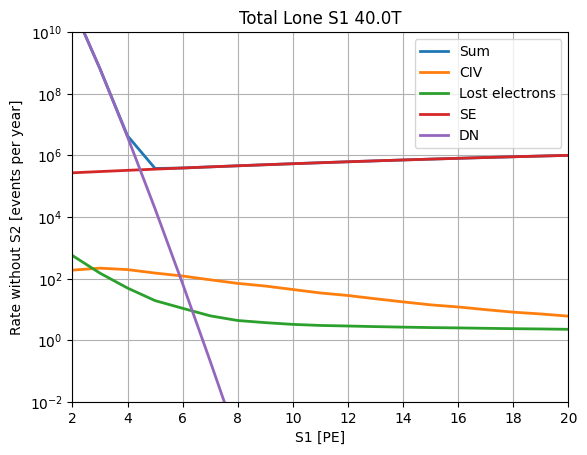

In [38]:
#Now add misclassified SE to S1 rate. 
# Single electrons are amplified given the SEgain.
# The SE gain spectrum is quite wide, so some fraction of them shows up at 
# much lower PE than they should and can be misclassified as an S1 with some probability.
R_LS1_all = []
R_LS1_SE = []


SErate = instrumentalBackgrounds.RUnexplainedS2(0)*instrumentalBackgrounds.S1MisclassificationProb 

for i in range(len(x_LS1_PE)):
    R_LS1_SE.append(0)
    R_LS1_all.append(0)

    R_LS1_SE[i] = SErate*instrumentalBackgrounds.SESpectrum(x_LS1_PE[i])
    R_LS1_all[i] = R_LS1_SE[i] + R_LS1_FromCIV_PE[i] + R_LS1_Rad_PE[i]

    if i < len(y_DNCoincidenceRate):
        R_LS1_all[i] = R_LS1_all[i] + y_DNCoincidenceRate[i]


fig_noS2total, ax_noS2total = plt.subplots()
ax_noS2total.semilogy(x_LS1_PE, R_LS1_all, linewidth=2.0, label="Sum")
ax_noS2total.semilogy(x_LS1_PE, R_LS1_FromCIV_PE, linewidth=2.0, label="CIV")
ax_noS2total.semilogy(x_LS1_PE, R_LS1_Rad_PE, linewidth=2.0, label="Lost electrons")
ax_noS2total.semilogy(x_LS1_PE, R_LS1_SE, linewidth=2.0, label="SE")
ax_noS2total.semilogy(x_DN, y_DNCoincidenceRate, linewidth=2.0, label="DN")
ax_noS2total.grid()
plt.xlim([2, 20]) 
plt.ylim([1e-2, 1e10]) 
ax_noS2total.legend(loc='upper right')
ax_noS2total.set_xlabel("S1 [PE]")
ax_noS2total.set_ylabel("Rate without S2 [events per year]")
ax_noS2total.set_title(f"Total Lone S1 {np.round(detector.activeMass)}T")   
plt.savefig("lone_S1.pdf", format="pdf",bbox_inches="tight")
for i in range(4):
    print (str(i) + ": " + str(x_LS1_PE[i]) + ", " + str(R_LS1_all[i]))

rate in red box is 54272.4175 events/year
rate in red box is 1356.1140 events/tonne.year


(67, 79)

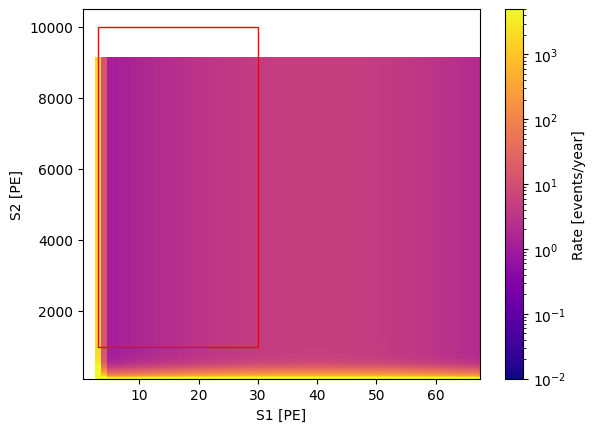

In [39]:
# Mixing them up
## 
## Lone-S1: x_LS1_PE, R_LS1_all
## Lone-S2: x_LS2, R_LS2_all
X_mix, Y_mix = np.meshgrid(x_LS1_PE, x_LS2_PE)
Z_ACPDF = np.eye(len(x_LS2_PE),len(x_LS1_PE))
nfold = 3 # nfolds /coincidences
for i in range(len(R_LS1_all)):
    for j in range(len(R_LS2_all)):
        if (i <=nfold-2 or j==0):Z_ACPDF[j,i] = 0.0 #For 'i+2'-fold coincidence
        else: Z_ACPDF[j,i] =  R_LS1_all[i]*R_LS2_all[j]*detector.MaxDriftTime*1./ACClasses.SecondsPerYear*1e-9
        #note inverted "i,j" due to weird axis definitions in np.meshgrid


ens = [1., 2.] 
yrange=(1,300)


fig_mix, ax_mix = plt.subplots()
levels = np.ndarray((5,), buffer=np.array([1e-10, 1e-8, 1e-6, 1e-4, 1e-2]))
#plt.xlim([1, 25]) 
# plt.ylim([0, 1000]) 
im = ax_mix.pcolormesh(X_mix, Y_mix, Z_ACPDF, norm=colors.LogNorm(vmin=1e-2, vmax=5e3), cmap='plasma')
ax_mix.set_ylabel("S2 [PE]")
ax_mix.set_xlabel("S1 [PE]")

ax_mix.set_title("")
fig_mix.colorbar(im, ax=ax_mix, label="Rate [events/year]")

#calculate rate in a box
xmin = 3
xmax = 30
ymin = 10**3
ymax = 10**4

rect = patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='r', facecolor='none')
ax_mix.add_patch(rect)
totalrate = 0.0
for i in range(len(X_mix[0])):
    for j in range(len(Y_mix[1])):
        if (X_mix[0][i] >= xmin and X_mix[0][i] < xmax):
            if (Y_mix[j,i] >= ymin and Y_mix[j,i] < ymax):
                #print("x:" + str (X_mix[0][i]) + ", y:" + str(Y_mix[j,i]) + " :" + str(Z_mix[j,i]))
                totalrate = totalrate + Z_ACPDF[j,i]

print("rate in red box is " + "{:.4f}".format(totalrate) + " events/year")
print("rate in red box is " + "{:.4f}".format(totalrate/detector.activeMass) + " events/tonne.year")
rate = totalrate/detector.activeMass
plt.savefig("AC_S1S2.pdf", format="pdf",bbox_inches="tight")
Z_ACPDF_transpose= np.transpose(Z_ACPDF) #To convert it since it was filled like Z_ACPDF[j,i] and not Z_ACPDF[i, j], have to transpose it
Z_ACPDF_transpose.shape

In [40]:
S1_bin = np.linspace(0.0, 150.0, 151)
S2_bin = np.logspace(2,4.75, 110+1)       
S1_mix,S2_mix = np.meshgrid(S1_bin, S2_bin)
print(np.where(S2_bin >= 1e3))
print(S2_bin[80])

extended_Z_ACPDF = np.zeros((151, 111))
extended_Z_ACPDF[3:30,40:79] = Z_ACPDF_transpose[3:30,40:]

Z_ACPDF_final = []
for i in range(len(extended_Z_ACPDF)-1):
    for j in range(len(extended_Z_ACPDF[0])-1):
        avg = (extended_Z_ACPDF[i, j] + extended_Z_ACPDF[i, j+1] + extended_Z_ACPDF[i+1, j] + extended_Z_ACPDF[i+1, j+1])*0.25
        Z_ACPDF_final.append(avg)
Z_ACPDF_final = np.array(Z_ACPDF_final)
Z_ACPDF_final = np.reshape(Z_ACPDF_final, (150, 110))


(array([ 40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110]),)
10000.0


In [41]:
#Convert to template for binference
fold = nfold
trigger="n4tw200" 
field = detector.DriftField
configuration=round(detector.activeMass,-1)
version = "v0.1.0"
binf_folder = f"Pranathi_XLZD_{configuration}T_{fold}fold_base_binf_{trigger}_{field}Vcm_{version}"
binf_comp = 'AC'
if not os.path.isdir(binf_folder):
    yes_answer = {'yes','y', 'ye', ''}
    if input("Create directory? ").lower() in yes_answer:
        os.makedirs(binf_folder)
helpers.numpy_to_template(
    bins=[S1_bin, np.log10(S2_bin)], 
    histograms=[Z_ACPDF_final/detector.activeMass], 
    file_name= os.path.join(binf_folder, binf_comp+f'_XLZD_{configuration}T_Template_{fold}fold_p.hdf'), 
    histogram_names = ['hmc'], 
    axis_names = ['cS1', 'log10(cS2)'],
    metadata={"version":"0.1.0",
                "date":datetime.now().strftime('%Y%m%d_%H:%M:%S'),
                "field":field,
                "s1trigger":trigger
                }
    )

# This makes the template as per Pranathi's workflow : lprincipe/amirr/FlameFitSimple/FlameFitSimple/analyses/wimp_sensitivity/AC_backgrounds/XLZD_base_binf_n4tw200_290Vcm_v0.1.0 the file get's saved here for example, depending upon user input drift field

file f opened, 1st time,  []
writing histogram name hmc


In [42]:
#fixme. z-dependent corrections
# 1) translate #e- -> PE
# S1/S2 identification threshold is in uncorrected data in S1, S2
# 2) apply correction, at first order due to LCE as function of Z
# In Xe, LCE is normalized to center of TPC. At this point, could add S2-width cut


79.7874166780039


(2.0, 5.0)

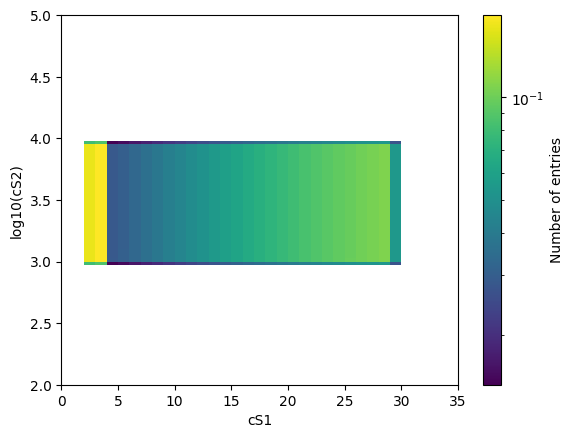

In [43]:
file_path = '/Users/amirr/Desktop/Flame/FlameFitSimple/analyses/wimp_sensitivity/AC_background/Pranathi_XLZD_40.0T_3fold_base_binf_n4tw200_240Vcm_v0.1.0/AC_XLZD_40.0T_Template_3fold_p.hdf'
AC_temp=inference_interface.template_to_multihist(file_path)['hmc']
AC_temp.plot(norm=colors.LogNorm()) # This should output the AC template
print(AC_temp.n)

plt.xlim([0,35])
plt.ylim([2,5])


# WE now rebin for XLZD and use the final template at the end for inference 

1356.114043973938


(<matplotlib.collections.QuadMesh at 0x12ff708f0>,
 <matplotlib.colorbar.Colorbar at 0x12ff0bb30>)

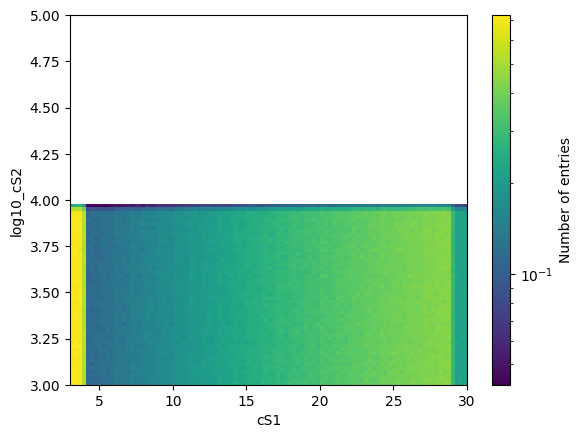

In [44]:

N=int(1e7)
ToyData=AC_temp.get_random(N)
cs1=list(zip(*ToyData))[0]
cs2=list(zip(*ToyData))[1]
df=pd.DataFrame({'cS1':cs1,'log10_cS2':cs2})
df=df.query('3<cS1<30 & 3<log10_cS2<5')
binning=[np.linspace(3, 30, 101), np.linspace(3, 5, 101)]
hist,edges=np.histogramdd((df['cS1'],df['log10_cS2']),bins=binning)
mh_hist=mh.Histdd.from_histogram(hist,edges,axis_names=['cS1','log10_cS2'])

#print(mh_hist.n)
mh_hist = mh_hist/mh_hist.n
mh_hist *= rate

print(mh_hist.n)

mh_hist.plot(norm=colors.LogNorm())


In [45]:
path = '/Users/amirr/Desktop/Flame/FlameFitSimple/analyses/wimp_sensitivity/AC_background/'
mass = round(detector.activeMass,-1)
driftV = int(detector.DriftField)
fold = nfold
name = 'XLZD'

directory = f'{path}{name}_{mass}T_{fold}folds_{driftV}Vcm_v0.1.0_Final'
if os.path.exists(directory):
    shutil.rmtree(directory)
os.mkdir(directory)
inference_interface.multihist_to_template([mh_hist], f'{directory}/AC_{name}Template_{fold}fold.hdf')

In [48]:
# Define file path
file_path = "/Users/amirr/Desktop/Flame/FlameFitSimple/analyses/wimp_sensitivity/AC_background/XLZD_40.0T_4folds_240Vcm_v0.1.0_Final/AC_XLZDTemplate_4fold.hdf"
AC_temp=inference_interface.template_to_multihist(file_path)['%i']
print(AC_temp.n)

52.30938796736285
